# Kmeans on wavelet transforms

In [127]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import plotly.express as px 
import plotly.graph_objects as go 
import concurrent.futures
import gc
from kneed import KneeLocator

from one.api import ONE

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//4_analyses/4_Clustering//'
os.chdir(functions_path)
from clustering_functions import GMM_neg_log_likelihood
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from postprocessing_functions import remove_states_str, state_identifiability, align_bin_design_matrix, states_per_trial_phase, broader_label
from plotting_functions import plot_avg_state, wheel_over_wavelet_clusters, plot_states_aligned

one = ONE(mode='remote')

## Parameters

In [128]:
# Parameters
bin_size = 0.017
multiplier=1
num_states = 2
num_train_batches = 5

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

# LOAD DATA
cv_results_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
data_path ='/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
grid_search_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/grid_search/individual_sessions/'

all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

use_sets = [['avg_wheel_vel'], ['whisker_me'], ['Lick count'], ['0.25', '0.5',
    '1.0', '2.0', '4.0', '8.0', '16.0']]
var_interest_map = ['avg_wheel_vel', 'whisker_me', 'Lick count', 'wavelet']
idx_init_list = [0, 1, 2, 3]
idx_end_list = [1, 2, 3, 10]

use_sets = [['avg_wheel_vel'], ['whisker_me'], ['Lick count'], ['0.5',
    '1.0', '2.0', '4.0', '8.0']]
var_interest_map = ['avg_wheel_vel', 'whisker_me', 'Lick count', 'wavelet']
idx_init_list = [0, 1, 2, 4]
idx_end_list = [1, 2, 3, 9]

var_interest = 'wavelet'


# Kmeans on wavelet transform

In [129]:
# Identify sessions availableto process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    sessions_to_process.append((mouse_name, session))


In [130]:

def plot_mean_cluster(cluster_features, plt_vars):
    plt.rcParams.update({'font.size': 16})

    # Get viridis color palette
    unique_clusters = cluster_features['most_likely_states'].unique()
    colors = sns.color_palette("viridis", len(unique_clusters)).as_hex()  # Get hex colors

    # Create the figure
    fig = go.Figure()

    for i, cluster in enumerate(unique_clusters):
        fig.add_trace(go.Scatterpolar(
            r=np.array(cluster_features.loc[cluster_features['most_likely_states'] == cluster, plt_vars])[0],
            theta=plt_vars,
            fill='toself',
            name=f'Wavelet transform cluster {cluster}',
            line=dict(color=colors[i])  # Assign Viridis color
        ))

    fig.update_layout(
        polar=dict(
            angularaxis=dict(
                tickfont=dict(size=16)  # Set the font size of the theta labels
            ),
            radialaxis=dict(
                visible=True,
                tickfont=dict(size=16)
            )
        ),
        showlegend=True
    )

    fig.show()

### Save empirical state features per session

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/

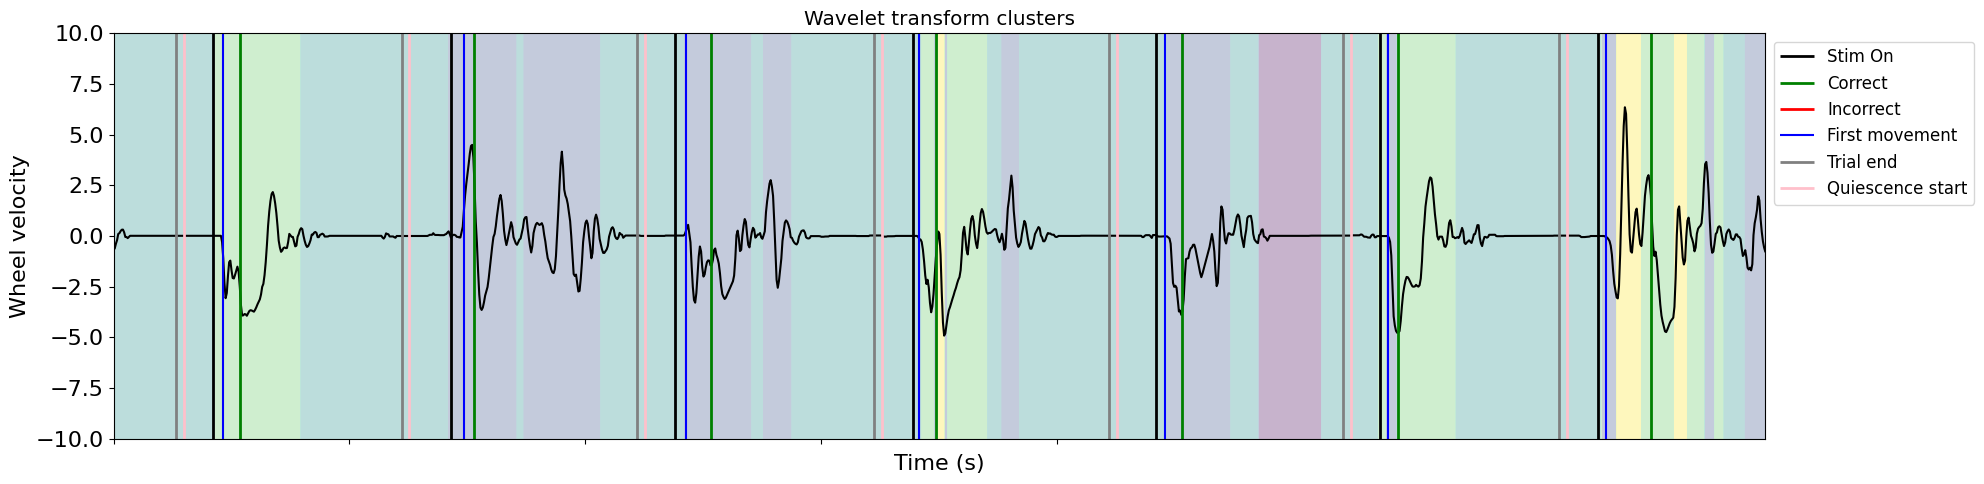

88224abb-5746-431f-9c17-17d7ef806e6a


/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/

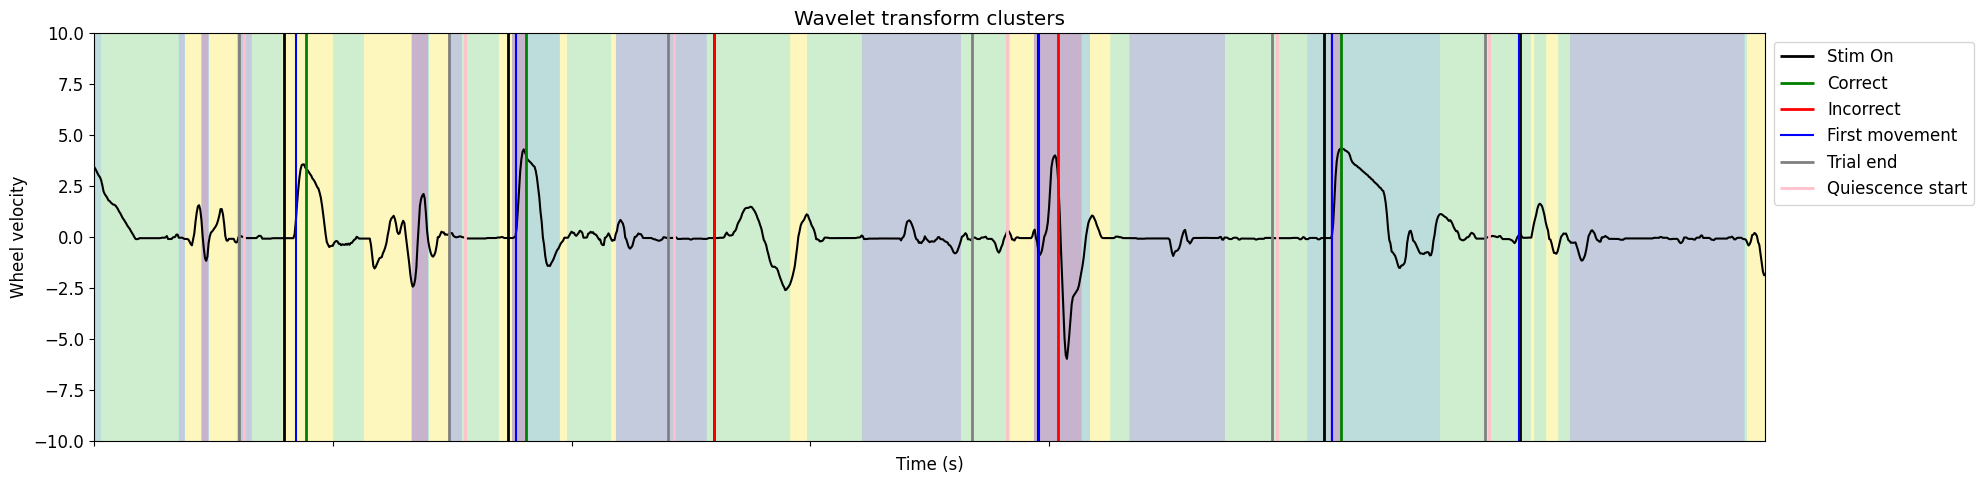

bb6a5aae-2431-401d-8f6a-9fdd6de655a9


/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/

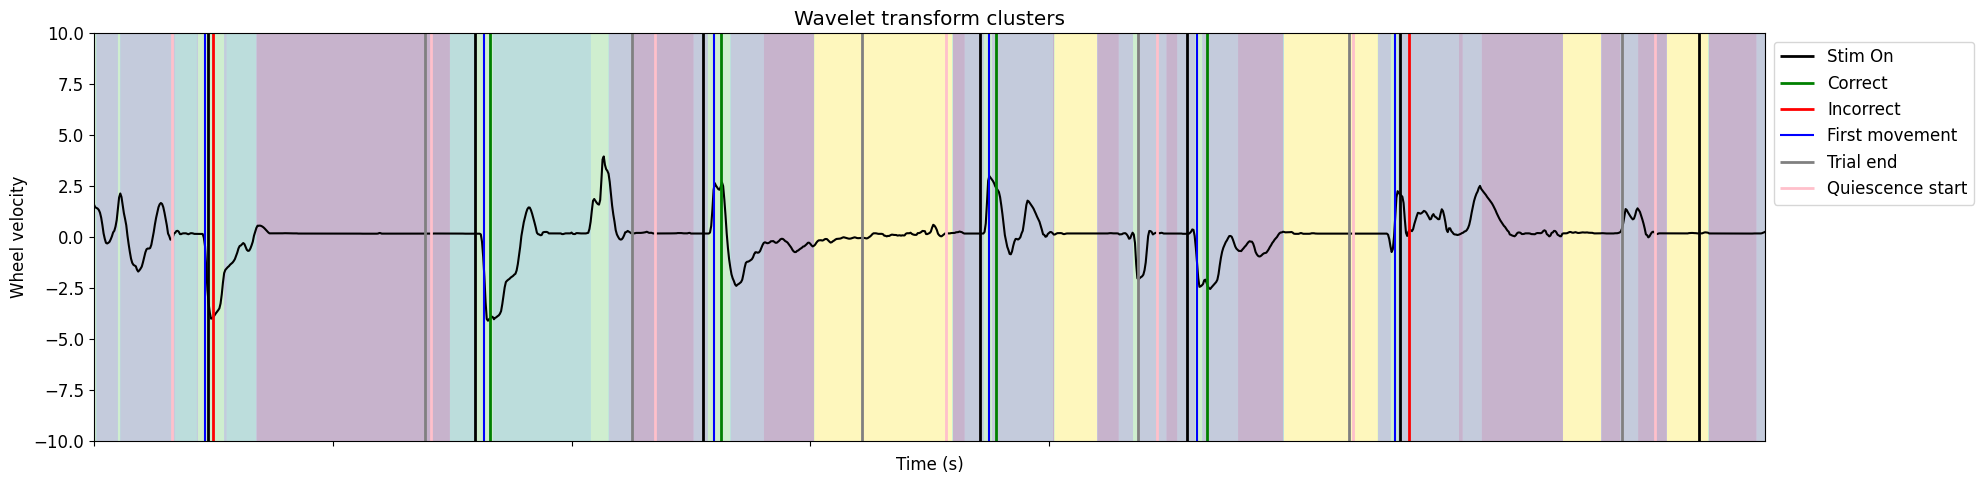

671c7ea7-6726-4fbe-adeb-f89c2c8e489b


/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/

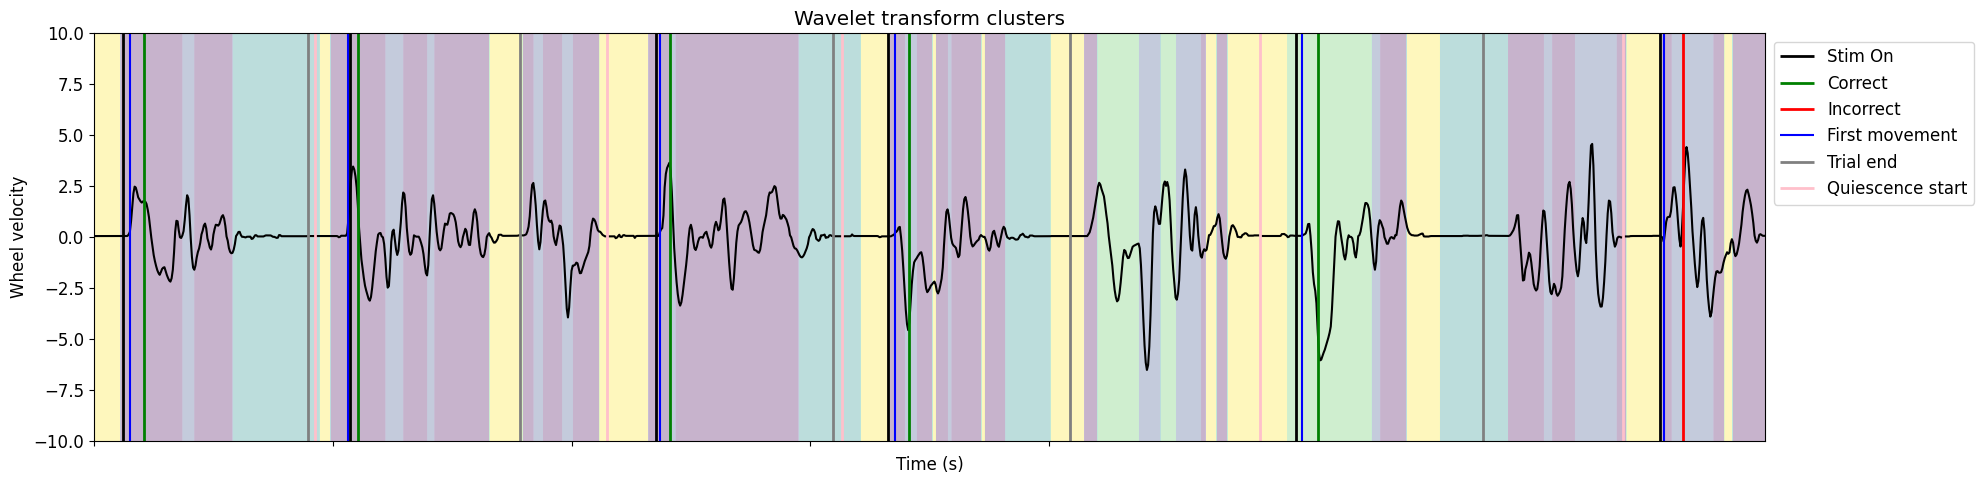

2c44a360-5a56-4971-8009-f469fb59de98


/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/

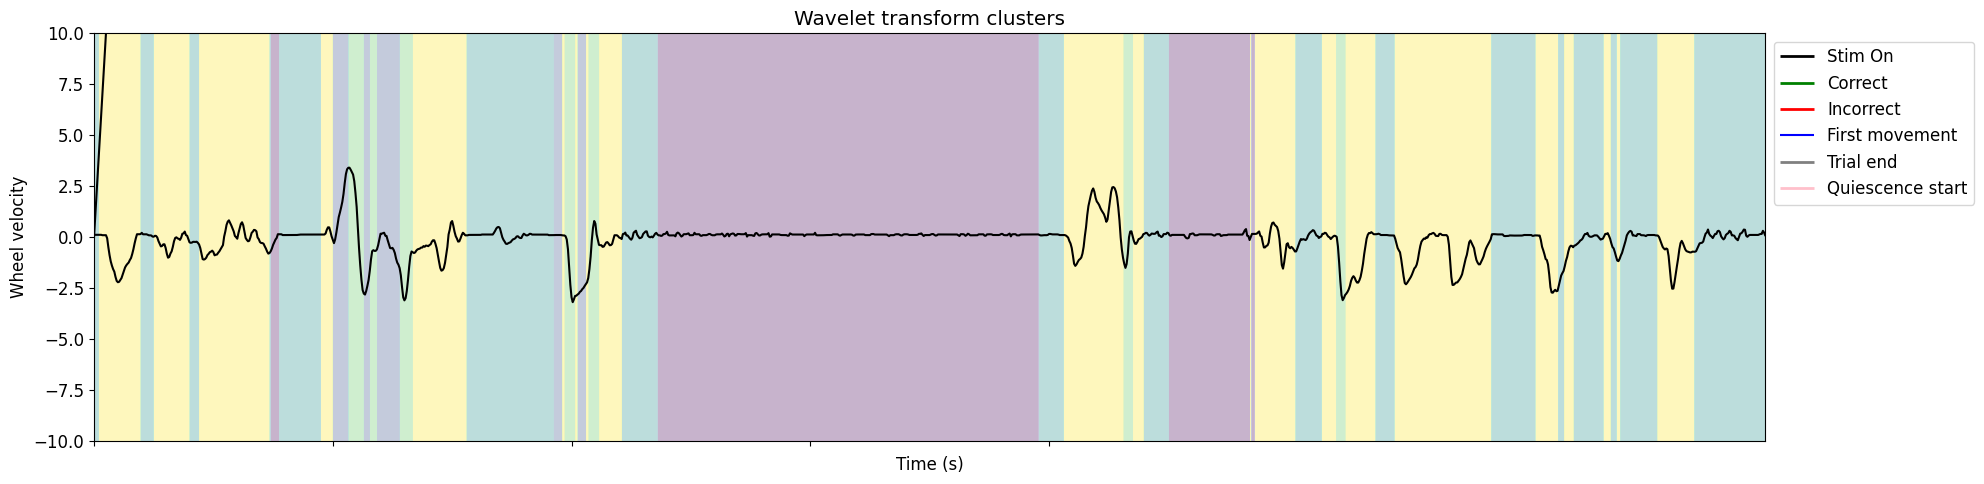

6f09ba7e-e3ce-44b0-932b-c003fb44fb89


/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/

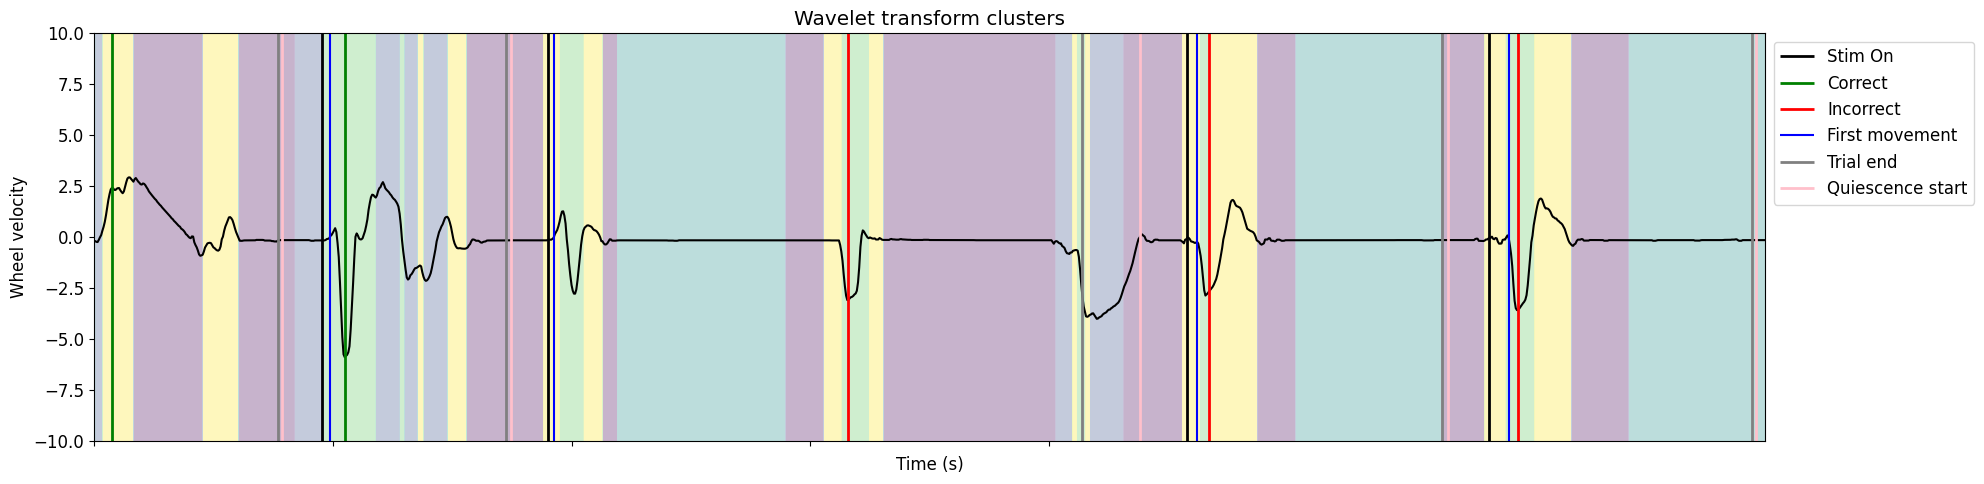

446f4724-1690-49f9-819a-2bd8e2ea88ce


/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/

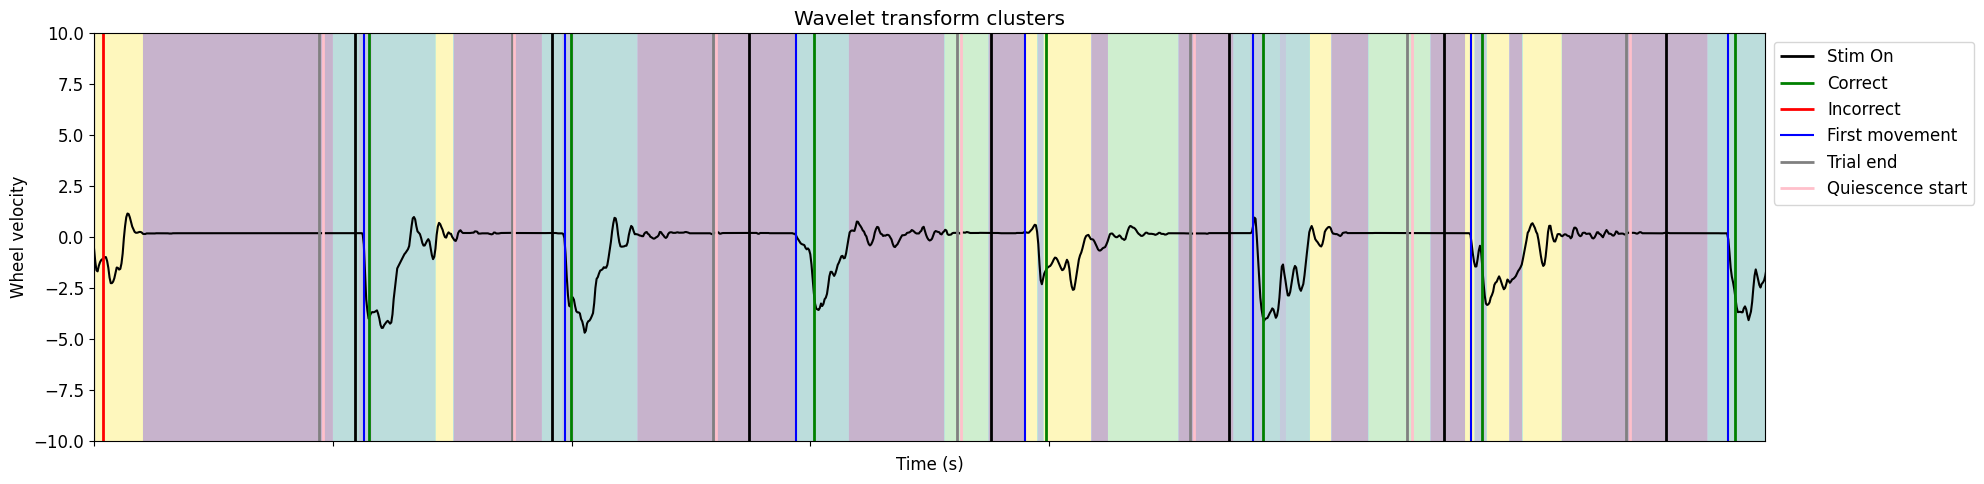

821f1883-27f3-411d-afd3-fb8241bbc39a


/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/

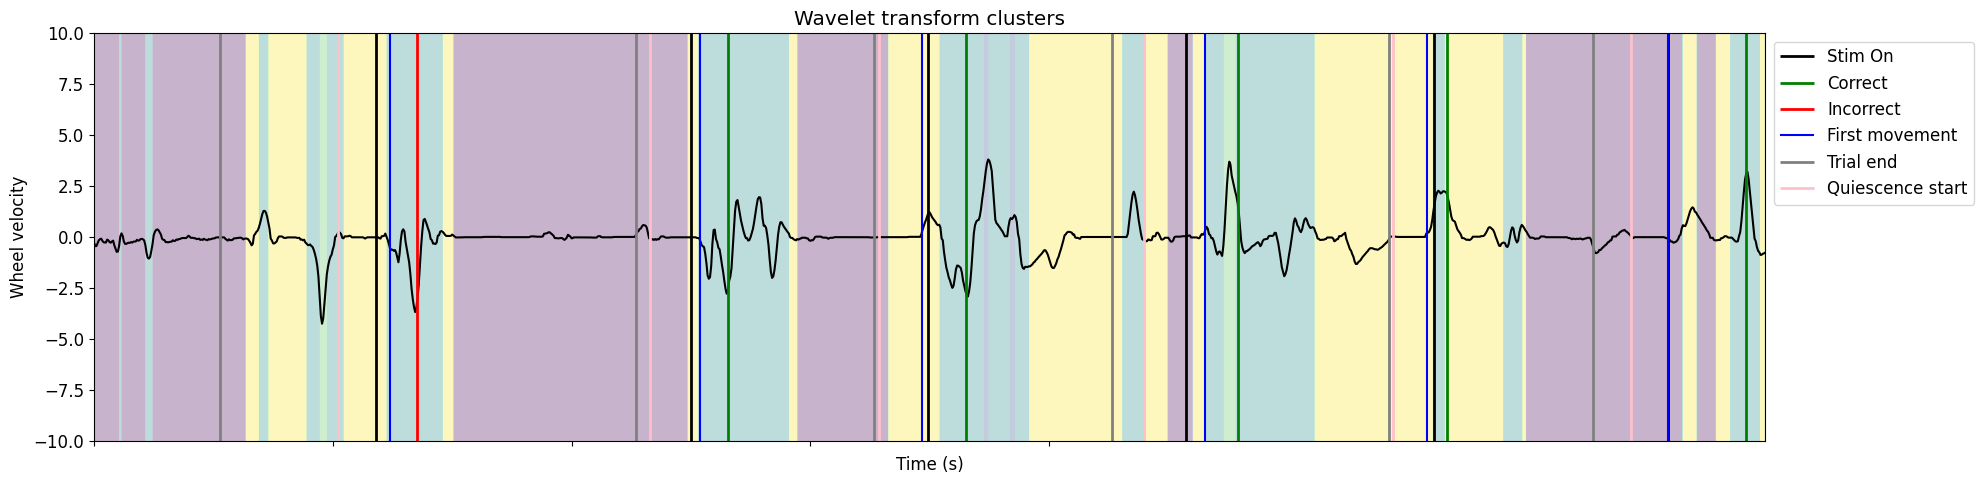

fc43390d-457e-463a-9fd4-b94a0a8b48f5


/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/

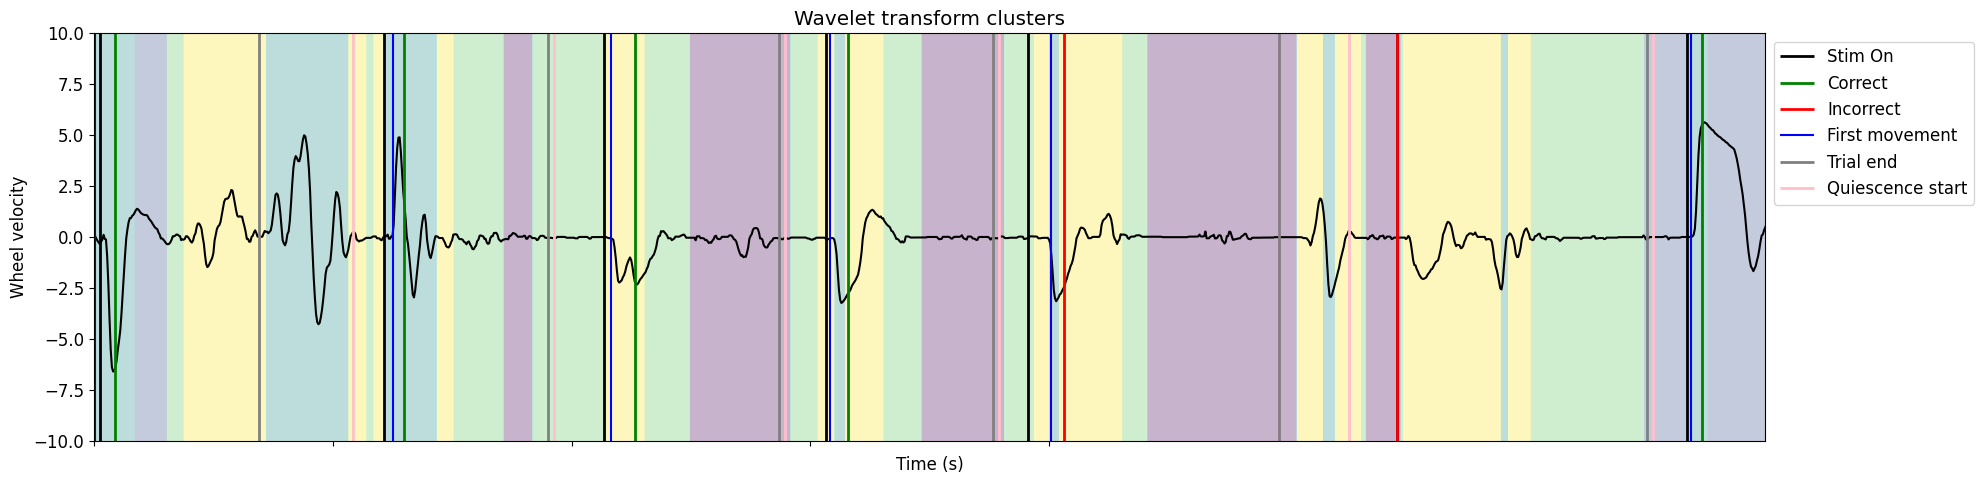

90d1e82c-c96f-496c-ad4e-ee3f02067f25


/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/

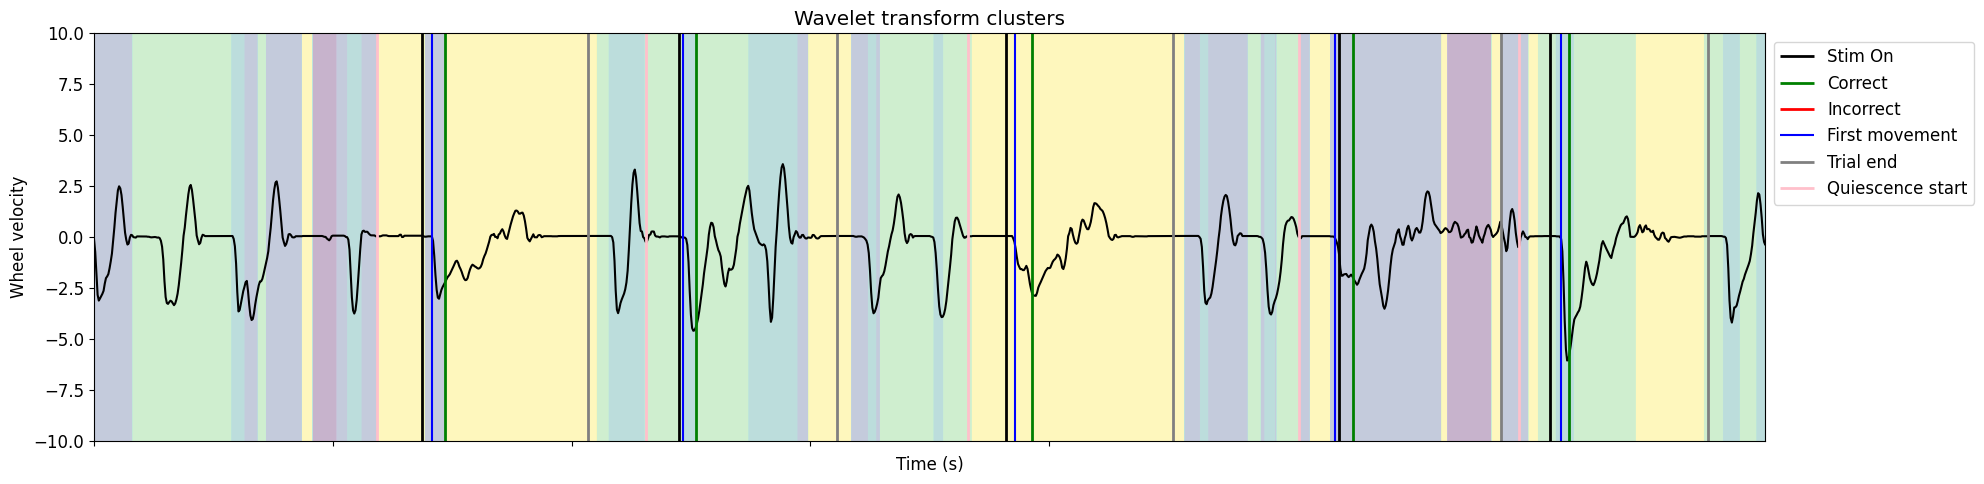

83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4


In [132]:
all_cluster_features = pd.DataFrame(columns=['mouse_name', 'session', 'most_likely_state', 'abs_wheel_vel', '0.5', 
                                                                                            '1.0', '2.0', '4.0', '8.0'])
index_var = np.where(np.array(var_interest_map)==var_interest)[0][0]
idx_init = idx_init_list[index_var]
idx_end = idx_end_list[index_var]
var_names = use_sets[index_var]

for m, mat in enumerate(sessions_to_process[:10]):

    mouse_name = mat[0]
    session = mat[1]

    fit_id = str(mouse_name+session)

    # Get session data
    filename = data_path + "session_trials_" + str(session) + '_'  + mouse_name
    session_trials = pd.read_parquet(filename, engine='pyarrow').reset_index()  # I think resetting index is what gives the trial number?
    # Get design_matrix
    filename = data_path + "design_matrix_" + str(session) + '_'  + mouse_name
    unnorm_design_matrix =  pd.read_parquet(filename, engine='pyarrow').dropna().reset_index()
    # Get standardized design_matrix
    filename = data_path + "standardized_design_matrix_" + str(session) + '_'  + mouse_name
    standardized_designmatrix = np.load(filename+str('.npy'))
    filtered_matrix = standardized_designmatrix[~np.isnan(standardized_designmatrix).any(axis=1)]  # Need to dropnans
    # design_matrix = np.abs(filtered_matrix.copy()[:, idx_init:idx_end])
    design_matrix = filtered_matrix.copy()[:, idx_init:idx_end]

    num_timesteps = np.shape(design_matrix)[0]
    data = design_matrix[:(num_timesteps // num_train_batches) * num_train_batches]
    # data = np.array(unnorm_design_matrix[var_names])[:(num_timesteps // num_train_batches) * num_train_batches].reshape(-1, 1)

    kmeans = KMeans(n_clusters=5, random_state=2024)
    kmeans.fit(data.copy())
    states = kmeans.predict(data.copy())
            
    " Prepare data "
    num_timesteps = np.shape(design_matrix)[0]
    use_var = ['avg_wheel_vel', '0.5', '1.0', '2.0', '4.0', '8.0']
    design_matrix_heading = pd.DataFrame(columns=use_var)
    design_matrix_heading[var_names] = design_matrix[0:len(states)]  # TODO: need to understand why number is the same and whether it depends on lag
    bins = unnorm_design_matrix[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
    design_matrix_heading['Bin'] = bins
    design_matrix_heading['avg_wheel_vel'] = filtered_matrix[:len(data), 0]

    # Align bins
    init = -1 * multiplier
    end = 1.5 * multiplier
    empirical_data = align_bin_design_matrix(init, end, event_type_list, session_trials, design_matrix_heading, states, multiplier)
    # empirical_data = empirical_data.drop(columns=['new_bin'])
    # empirical_data['identifiable_states'] = identifiable_states
    
    """ Trial types """
    # Split in trial types
    states_trial = states_per_trial_phase(empirical_data, session_trials, multiplier)
    states_trial['mouse_name'] = mouse_name
    states_trial['session'] = session
    states_trial = broader_label(states_trial)
    
    # Plot raw trace over states       
    init = 400
    inter = 1000
    wheel_over_wavelet_clusters(init, inter, empirical_data, session_trials)
    print(session)
    
    # # Plot states statistics
    # use_df = unnorm_design_matrix[:(num_timesteps // num_train_batches) * num_train_batches]
    # bins = use_df[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
    # use_df['Bin'] = bins
    # use_df['avg_wheel_vel'] = filtered_matrix[:len(data), 0]

    # # Align bins
    # init = -1 * multiplier
    # end = 1.5 * multiplier
    # empirical_data2 = align_bin_design_matrix(init, end, event_type_list, session_trials, use_df, states, multiplier)
    # empirical_data2['abs_wheel_vel'] = np.abs(empirical_data2['avg_wheel_vel'])

    # cluster_features = pd.DataFrame(empirical_data2.groupby(['most_likely_states'])['abs_wheel_vel', '0.5', 
    #                                                                                         '1.0', '2.0', '4.0', '8.0'].mean()).reset_index()
    # # Save to big data frame with all animals
    # cluster_features['mouse_name'] = mouse_name
    # cluster_features['session'] = session    
    # all_cluster_features = all_cluster_features.append(cluster_features)
    
    # plt_vars = ['0.5', '1.0', '2.0', '4.0', '8.0']
    # plot_mean_cluster(cluster_features, plt_vars)
    # sns.barplot(x='most_likely_states', y='abs_wheel_vel', data=cluster_features)

In [111]:
use_df = all_cluster_features[['session', 'abs_wheel_vel']]
use_df = all_cluster_features.copy()
sorted_df = use_df.sort_values(by=['session', 'abs_wheel_vel'], ascending=[True, True], na_position='last').reset_index()
sorted_df['index'] = sorted_df.groupby('session').cumcount()

In [117]:
melted_df = pd.melt(sorted_df, id_vars=['session', 'index'], value_vars=['0.5', '1.0', '2.0', '4.0', '8.0'])

<Axes: xlabel='variable', ylabel='value'>

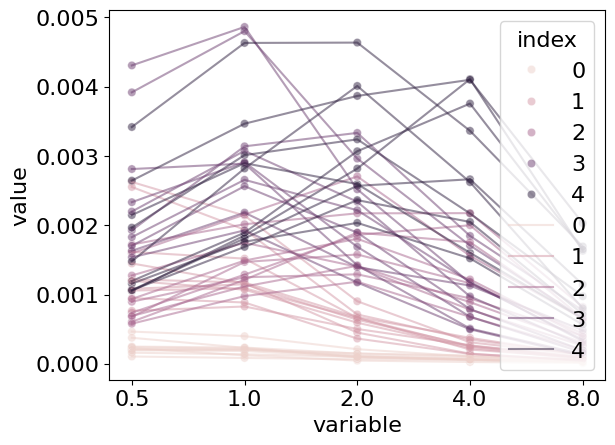

In [124]:
sns.scatterplot(hue='index', y='value', x='variable', data=melted_df, alpha=0.5)
sns.lineplot(hue='index', y='value', data=melted_df, x='variable', units='session', estimator=None, alpha=0.5)

AttributeError: PathCollection.set() got an unexpected keyword argument 'units'

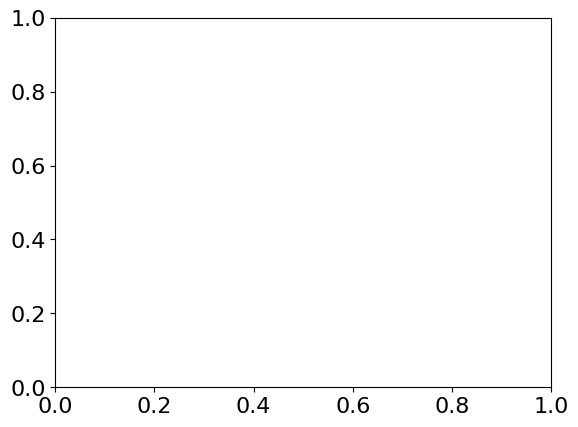

In [110]:
sns.scatterplot(x='index', y='abs_wheel_vel', data=sorted_df)
sns.lineplot(x='index', y='abs_wheel_vel', data=sorted_df, units='session', estimator=None)

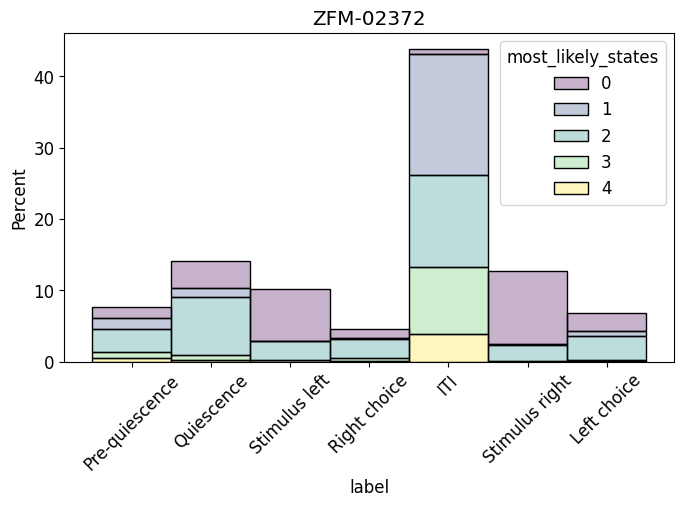

In [21]:
        """ Plot states per trial epoch """
        colors = sns.color_palette("viridis", 5)
        # states_trial = states_per_trial_phase(empirical_data, session_trials, multiplier)
        # states_trial = states_per_trial_phase(empirical_data, cont_trials, multiplier)
        plt.figure(figsize=[7, 5])
        sns.histplot(x='label', hue='most_likely_states', data=states_trial, stat = 'percent',
                            multiple="stack", legend=True, palette='viridis', alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.title(mouse_name)
        plt.show()
        
        # plot_states_trial_type(states_trial)